# Pattern Recognition - HW2 - 98722278
This notebook contains following sections:
1. Importing Libraries
2. Preparing Data
    1. Reading
    2. Normalizing
    3. K-Fold
3. Algorithms
    1. AdaBoostM2
    2. RUSBoost
    3. SMOTEBoost
    4. RBBoost
    5. SVC (sklearn)
    6. RandomForest (sklearn)
4. Visualizations
    1. Accuracies Table
    1. Accuracies Bar Plot
    2. Precisions-Recalls Bar Plot
    4. AUC Bar Plots
    5. ROC Curves
5. ANOVA Measure
    1. Preparing Data
    2. Training Models
    3. F-Score
    4. HSD

## 1 Importing Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, roc_curve

import random

import matplotlib.pyplot as plt

%matplotlib inline

seed=122334445
np.random.seed(seed)
random.seed(seed)

## 2 Preparing Data
1. Reading
2. Normalizing
3. K-Fold

### 2.A Reading
Just reading the data using pandas and converting `negative` to `0` and `positive` to `1`.

This dataset contains 514 samples of two classes which is unbalanced with a ratio of approximately `9`. These samples have `8` real features roughly in range of  [0, 1].

In [2]:
header = ['Mcg', 'Gvh', 'Alm', 'Mit', 'Erl', 'Pox', 'Vac', 'Nuc', 'class']
df = pd.read_csv('data/yeast-2_vs_4.dat', names=header, skiprows=13)
print(df.head())
df['class'] = df['class'].apply(lambda x:0 if x=='negative' else 1)

df_np = df.to_numpy()
x = df_np[:,:-1]
y = df_np[:,-1]

print('Number of samples', len(y))
print('Number of minority class', np.sum(y == 1))
print('Number of majority class', np.sum(y == 0))

    Mcg   Gvh   Alm   Mit  Erl  Pox   Vac   Nuc     class
0  0.51  0.40  0.56  0.17  0.5  0.5  0.49  0.22  negative
1  0.40  0.39  0.60  0.15  0.5  0.0  0.58  0.30  negative
2  0.40  0.42  0.57  0.35  0.5  0.0  0.53  0.25  negative
3  0.46  0.44  0.52  0.11  0.5  0.0  0.50  0.22  negative
4  0.47  0.39  0.50  0.11  0.5  0.0  0.49  0.40  negative
Number of samples 514
Number of minority class 51
Number of majority class 463


### 2.B Normalization
As the data itself is not normalized, in some cases normalizing data to have zero mean and standard deviation of 1, helps the algorithm to not get affected by features that have higher range than the others. Also, it helps the algorithm to converge faster in some cases. 

In [3]:
# normalizing
x = (x - x.mean(axis=0)) / x.std(axis=0)

print('Dataset X shape:', x.shape)
print('Dataset Y shape:', y.shape)

Dataset X shape: (514, 8)
Dataset Y shape: (514,)


### 2.C K-Fold
As we using algorithms like RUSBoost that behave stochasticly, we use 5 fold of input data 1 for test and 4 for training the algorithm and **averaging all metrics** such as accuracy over all folds and report one metric for each ensemble.

In [4]:
# K-Folds
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)

ensemble_sizes = [10, 50, 100]

## 3 Algorithms
1. AdaBoostM2
2. RUSBoost
3. SMOTEBoost
4. RBBoost
5. SVC (sklearn)
6. RandomForest (sklearn)

Before starting to explain about algorithms itself, we first need to choose a base classifier for ensembles. It has been shown (reference book of the course) that ensembles with **unstable** classifiers outperform ensembles with **stable** classifiers. So based on this confirmed theory, we prefer to use `DecisionTree` rather than `SVM`. **Unstable** classifiers enable us to incorporate higher effect of bias-variance change due to boosting methods which is what really we are looking for. 

Stable classifiers in large ensemles do not increase performance while computation increases much more.

But there is a particular type of tree that is common in ensembles called **Decision Stump** which is a decision tree with depth of 1 and this is the version we are using in our ensemble methods.

Why decision stump:
1. Decision trees overfit fully with zero training set error and have high variance while there are no learning biases. So we need simpler trees. Decreasing depth could help us. So if we have a huge number of weak classifiers that have good generalization but not fitted well, can perform better in ensembles.
2. Decision stumps only need one split, so they are fast.
3. As we are using boosting in all implemented algorithms except SVC and RandomForest and the base algorithm of updating weights and training classifiers all are AdaBoost M2, the comparison in [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html#sphx-glr-auto-examples-ensemble-plot-adaboost-hastie-10-2-py) approves that using decision stumps can outperfom other kind of trees with a huge distance. 

In image, AdaBoost classifier has been trained using decision stumps.

![decision stump performance](wiki/1.png)

On top of it we need to understand the difference between **boosting** and **averaging**. Ensembles like AdaBoost, SMOTEBoost, etc use weak classifiers and try to train them sequentially which means further classifiers use the knowledge of previous classifiers to perform better. This knowledge transfers via updating weights of samples and modifying train data to each classifier. Meanwhile, Averaging approaches such as RandomForest, train multiple base classifiers independently and try to average their votes to get the final output class.

Boosting enable ensemble to have low bias as each classifier learn to work well on a part of feature space and small variance as the ensemble average all classifiers hypotheses generated from different subsamples of the data.

As we can see at the end of the notebook in visualization section, RandomForest approach completely fail to capture minority data.

### 3.A AdaBoost M2
This is the algorithm we use in SMOTEBoost, RUSBoost and RBBoost to update weights and train classifiers. So all the lines here are also available in the other ensembles with a tiny modification.

Note that in binary classification, AdaBoost M1 is identical to AdaBoost M2 as they only differ for multiclass classification.

Here are the steps AdaBoost takes:
1. Consider uniform weight for all samples in train set
2. Train a weak classifier given weights and whole train set
3. Calculate a loss which is sum of the weights of all misclassified instances in train set
4. Calculates Alpha term for weight updating
5. Ignores classifier if it performs worse than random classifier p <= 0.5
6. Decrease the weight of samples that weak classifier predicted correctly by \*Alpha.
Decreasing weight of correctly classified instances, enable the ensemble to learn instances that are harder and previous weak classifiers failed to learn. It increases generalization and introduces low-variance classifiers.
7. Go to step 2 untill all classifiers in ensemble are trained
8. Use weighted majority vote for inference time

In [5]:
class AdaBoostM2:
    def __init__(self, x, y, n_classifier, base=None, weights=None, **kwargs):
        """
        Initialize AdaBoost M2 (Weight init is same as M1)
        
        :param x: input feauture in shape of (samples, features)
        :param y: input label in shape of (samples, )
        :param base: base classifier (default Decision Tree)
        :param n_classifier: number of base classifier in ensemble
        :param weights: init model with pretrained weights
        
        :return: A AdaBoost model
        """
        self.x = x
        self.y = y
        self.base = base
        if self.base is None:
            self.base = DecisionTreeClassifier
        self.n_classifier = n_classifier
        self.classifiers = []
        self.weights = weights
        self.alpha = []
        self.bad_classifier_idx = []
        
        # init ensemble
        for n in range(self.n_classifier):
            self.classifiers.append(self.base(**kwargs))
        
        if self.weights is None:
            # init weights using uniform distrobution
            self.weights = np.ones(len(self.x)) / len(self.x)
            
    def predict(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (samples, features)
        
        :return: a prediction of classes in label encoded form with shape of (samples, )
        """
        
        prediction = np.zeros((len(x),))
        for idx in range(len(x)):
            prediction[idx] = self.__predict_single_instance(x[idx].reshape(1, -1))
        return prediction
            
    def __predict_single_instance(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (1, features)
        
        :return: a prediction of classes in label encoded form with shape of (1, )
        """
        p = np.zeros((1, 2))
        for n in range(self.n_classifier):
            if n not in self.bad_classifier_idx:
                if self.classifiers[n].predict(x) == 1:
                    p[0,1] += np.log(1 / (self.alpha[n]+1e-10))
                else:
                    p[0,0] += np.log(1 / (self.alpha[n]+1e-10))
        p[:,1] += 1e-10 
        return np.argmax(p, axis=1)
    
    
    def fit(self):
        """
        Train the ensemble using base weak classifiers
        """
        for t in range(self.n_classifier):            
            
            # training weak classifier
            self.classifiers[t].fit(self.x, self.y, sample_weight=self.weights)
                        
            # calculating loss = sum of missclassified weights
            miss_w = self.weights[(self.classifiers[t].predict(self.x) != self.y).nonzero()[0]]
            loss = np.sum(miss_w) / 2 
            
            # calculating beta
            a = loss / (1 - loss)
            self.alpha.append(a)
            
            # drop classifiers with acc < 0.5
            if self.classifiers[t].score(self.x, self.y) <= 0.5:
                self.bad_classifier_idx.append(t)
                continue

            # update weights
            correct_pred_idx = (self.classifiers[t].predict(self.x) == self.y).nonzero()[0]
            self.weights[correct_pred_idx] = self.weights[correct_pred_idx] * a
            
            # normalize weights
            z = np.sum(self.weights)
            self.weights = np.array([w / z for w in self.weights])
             
    
    def score(self, x, y):
        p = self.predict(x)
        return np.sum((p == y)*1) / len(y)   

# Test
# model = AdaBoostM2(x=x_train, y=y_train, n_classifier=100, base=DecisionTreeClassifier, max_depth=1)
# model.fit()
# model.score(x_test, y_test)

In [6]:
adaboost_accuracies = []  # accuracies of different ensembles given 5 folds
adaboost_pr = []  # precision-recall of different ensebmles given 5 folds
adaboost_auc = []  # auc score of different ensebmles given 5 folds
adaboost_roc = []  # roc curve values of different ensebmles given 5 folds

for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 folds
    kf_pr = []  # precision-recall of 5 folds
    kf_auc = []  # auc of 5 folds
    kf_roc = []  # roc of 5 folds
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = AdaBoostM2(x=x_train, y=y_train, n_classifier=es, base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        kf_pr.append((p, r))
        kf_acc.append(accuracy_score(y_test, y_pred))
        kf_auc.append(roc_auc_score(y_test, y_pred, average='micro'))
        kf_roc.append(roc_curve(y_test, y_pred, pos_label=1)[:-1])
    adaboost_auc.append(kf_auc)
    adaboost_roc.append(kf_roc)
    adaboost_pr.append(kf_pr)
    adaboost_accuracies.append(kf_acc)
for idx,f in enumerate(adaboost_accuracies):
    print('Accuracy of ensemble with size of #{}:\n {} ---> AVG={}'.format(
        ensemble_sizes[idx], f, np.mean(adaboost_accuracies[idx])))

Accuracy of ensemble with size of #10:
 [0.95145631067961167, 0.91262135922330101, 0.970873786407767, 0.96116504854368934, 0.90196078431372551] ---> AVG=0.9396154578336189
Accuracy of ensemble with size of #50:
 [0.95145631067961167, 0.91262135922330101, 0.970873786407767, 0.96116504854368934, 0.90196078431372551] ---> AVG=0.9396154578336189
Accuracy of ensemble with size of #100:
 [0.95145631067961167, 0.91262135922330101, 0.970873786407767, 0.96116504854368934, 0.90196078431372551] ---> AVG=0.9396154578336189


### 3.B RUSBoost

RUSBoost uses same approach as is in AdaBoost but the only difference is that AdaBoost uses all train data but RUSBoost uses *Random Under Sampling* technique which is simple term, it uses a subset of train data each time to train weak classifiers but in the way that the balance of minority and majority tend to be lower as we only select a random subset of majority data. The method `__undersample` is the implementation of this approach.

In this implementation, at each iteration, a subset of majority data with same size of minority data will be selected so each weak classifier will be trained with same size of minority and majority data. (Random sampling with replacement)

Here are the steps RUSBoost takes:
1. Consider uniform weight for all samples in train set
2. Generate Random Under Sampling
    1. Add all minority samples to the new set *S*
    2. Add a unique subset of majority data with same size as minority data to the set S
3. Train a weak classifier given weights and subset sampled *S*
4. Calculate a loss which is sum of the weights of all misclassified instances in train set
5. Calculates Alpha term for weight updating
6. Ignores classifier if it performs worse than random classifier p <= 0.5
7. Decrease the weight of samples that weak classifier predicted correctly by \*Alpha.
8. Go to step 2 untill all classifiers in ensemble are trained
9. Use weighted majority vote for inference time

First obvious benefit of this approach is that in every iteration, we feed same amount of minority and majority class to each classifier so the classifiers will not be dominated by only majority class.

Another noticable feature of this algorithm is that it completely outperforms AdaBoost and in some cases SMOTEBoost or comparable result, it is much faster that SMOTEBoost and the algorithm is really simple to implement.

RUS uses undersampling which the first drawback is loosing information as we not using whole dataset. Meanwhile it decreases train time with same ratio of majority to whole dataset. But as RUS is combined with boosting feature, it enables to capture feature space well.

Although using RUS cause to classifier not to learn all feature space very well because of information loss, boosing enables it to decrease bias and capture most of the feature space.

Robustness to noise by using random sets.

Increasing *diversity* by working on data level.

In [6]:
class RUSBoost:
    def __init__(self, x, y, n_classifier, base=None, weights=None, **kwargs):
        """
        Initialize RUSBoost
        
        :param x: input feauture in shape of (samples, features)
        :param y: input label in shape of (samples, )
        :param base: base classifier (default Decision Tree)
        :param n_classifier: number of base classifier in ensemble
        :param weights: init model with pretrained weights
        
        :return: A RUSBoost model
        """
        self.x = x
        self.y = y
        self.base = base
        if self.base is None:
            self.base = DecisionTreeClassifier
        self.n_classifier = n_classifier
        self.classifiers = []
        self.weights = weights
        self.alpha = []
        self.bad_classifier_idx = []
        
        # init ensemble
        for n in range(self.n_classifier):
            self.classifiers.append(self.base(**kwargs))
        
        if self.weights is None:
            # init weights using uniform distrobution
            self.weights = np.ones((len(self.x))) / len(self.x)
            
    def predict(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (samples, features)
        
        :return: a prediction of classes in label encoded form with shape of (samples, )
        """
        
        prediction = np.zeros((len(x),))
        for idx in range(len(x)):
            prediction[idx] = self.__predict_single_instance(x[idx].reshape(1, -1))
        return prediction
            
    def __predict_single_instance(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (1, features)
        
        :return: a prediction of classes in label encoded form with shape of (1, )
        """
        p = np.zeros((1, 2))
        for n in range(self.n_classifier):
            if n not in self.bad_classifier_idx:
                if self.classifiers[n].predict(x) == 1:
                    p[0,1] += np.log(1 / (self.alpha[n]+1e-10))
                else:
                    p[0,0] += np.log(1 / (self.alpha[n]+1e-10))
        p[:,1] += 1e-10
        return np.argmax(p, axis=1)
    
    
    def fit(self):
        """
        Train the ensemble using RUS data boosting and base weak classifiers
        """
        for t in range(self.n_classifier):            
            # random under sampling
            rus_idx = self.__undersample()

            # training weak classifier
            self.classifiers[t].fit(self.x[rus_idx], self.y[rus_idx], self.weights[rus_idx])
            
            # calculating loss = sum of missclassified weights            
            miss_w = self.weights[(self.classifiers[t].predict(self.x) != self.y).nonzero()[0]]
            loss = np.sum(miss_w) / 2 
            
            # calculating beta
            a = loss / (1 - loss)
            self.alpha.append(a)
            
            # drop bad classifiers
            if self.classifiers[t].score(self.x, self.y) <= 0.5:
                self.bad_classifier_idx.append(t)
                continue
            
            # update weights
            correct_pred_idx = (self.classifiers[t].predict(self.x) == self.y).nonzero()[0]
            self.weights[correct_pred_idx] = self.weights[correct_pred_idx] * a
            
            # normalize weights
            z = np.sum(self.weights)
            self.weights = np.array([w / z for w in self.weights])
             
    
    def score(self, x, y):
        p = self.predict(x)
        return (p == y).nonzero()[0].__len__() / len(y)
           
    def __undersample(self):
        """
        Generates a random unique subset of majority data as same size as minority and return the indices
        
        :return: A sorted list of indices with shape of (2*minority_data, )
        """
        pos_size = len((self.y==1).nonzero()[0])
        neg_size = len((self.y==0).nonzero()[0])
        pos_data = self.x[self.y==1]
        neg_data = self.x[self.y==0]
        
        if pos_size > neg_size:
            self.major_data = pos_data
            self.minor_data = neg_data
            self.minor = 0
        else:
            self.minor_data = pos_data
            self.major_data = neg_data
            self.minor = 1
        # getting index of sampled intances for enabling correct weight update
        minor_idx = (self.y == self.minor).nonzero()[0]
        major_idx = (self.y == int(not self.minor)).nonzero()[0]
        major_idx = np.array(random.sample(list(major_idx), len(self.minor_data)))
        return sorted(np.concatenate((minor_idx, major_idx)))
    
# test
# model = RUSBoost(x=x_train, y=y_train, n_classifier=30, base=DecisionTreeClassifier, max_depth=1)
# model.fit()
# model.score(x_test, y_test)

In [8]:
rusboost_accuracies = []  # accuracies of different ensembles given 5 folds
rusboost_pr = []
rusboost_roc = []
rusboost_auc = []

for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 fold
    kf_pr = []
    kf_auc = []  # auc of 5 folds
    kf_roc = []  # roc of 5 folds
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RUSBoost(x=x_train, y=y_train, n_classifier=es, base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        kf_pr.append((p, r))
        kf_acc.append(accuracy_score(y_test, y_pred))
        kf_auc.append(roc_auc_score(y_test, y_pred, average='micro'))
        kf_roc.append(roc_curve(y_test, y_pred, pos_label=1)[:-1])
    rusboost_auc.append(kf_auc)
    rusboost_roc.append(kf_roc)
    rusboost_pr.append(kf_pr)
    rusboost_accuracies.append(kf_acc)
for idx,f in enumerate(rusboost_accuracies):
    print('Accuracy of ensemble with size of #{}:\n {} ---> AVG={}'.format(
        ensemble_sizes[idx], f, np.mean(rusboost_accuracies[idx])))

Accuracy of ensemble with size of #10:
 [0.92233009708737868, 0.93203883495145634, 0.90291262135922334, 0.970873786407767, 0.93137254901960786] ---> AVG=0.9319055777650866
Accuracy of ensemble with size of #50:
 [0.94174757281553401, 0.93203883495145634, 0.99029126213592233, 0.970873786407767, 0.92156862745098034] ---> AVG=0.951304016752332
Accuracy of ensemble with size of #100:
 [0.93203883495145634, 0.90291262135922334, 0.970873786407767, 0.90291262135922334, 0.91176470588235292] ---> AVG=0.9241005139920047


### 3.C SMOTEBoost

SMOTEBoost uses same approach as is in AdaBoost but the only difference is that AdaBoost uses all train data but SMOTEBoost uses *SMOTE* technique which is simple term, it tries to create a superset of minority data by exterpolation each time to train weak classifiers but in the way that the balance of minority and majority tend to be higher as we generating new samples from the feature space of minority class. The methods `__SMOTE`, `__KNN` and `__populate` are the implementation of this approach.

At each iteration, we create new samples of minority data w.r.t. `smote_ratio` factor. For instance, if we set it to 200, we will create twice as minority data and it will be appended to the original train set. This approach is using oversampling of minority data which is in contrary to RUS which uses undersampling of majority data. 

Here are the steps SMOTEBoost takes:
1. Consider uniform weight for all samples in train set + number of artificial samples
2. Generate SMOTE
    1. Create empty set S
    1. T = int(smote_ratio * size(minority) / 100) new instances will be generated
    2. x = Choose a random sample from minority data
    3. Find its k nearest neighbor using Euclidean distance
    4. nn = Choose a random neighbor within these k nearest neighbors
    5. Calculate the difference diff = nn - x 
    6. Update each feature of x = x + random_number * diff
    7. Add it to set S
    8. Go to step 2 untill generate T instances
3. Train a weak classifier given weights and artificial samples *S*
4. Discard set S
4. Calculate a loss which is sum of the weights of all misclassified instances in train set
5. Calculates Alpha term for weight updating
6. Ignores classifier if it performs worse than random classifier p <= 0.5
7. Decrease the weight of samples that weak classifier predicted correctly by \*Alpha.
8. Go to step 2 untill all classifiers in ensemble are trained
9. Use weighted majority vote for inference time

What SMOTE is doing here is that it generates new instances of minority data not by duplicating them, but by creating them from the feature space in the vicinity of the available data. It enables the ensemble to be more general and have fuller feature space for minority data. Meanwhile, as we use not only whole train set, also our artificial samples, the training time is about `smote_ration*imbalance_ratio/100` which is immensely more than RUSBoost algorithm. Also, SMOTE uses oversampling which can cause to overfitting.

Another noticable feature of this algorithm is that it completely outperforms AdaBoost and in some cases RUSBoost or comparable result, but it is much slower that RUSBoost and the algorithm is not simple as RUSBoost.

RUS used undersampling which caused it loosing of information which this does not exist in SMOTEBoost.

The overfitting problem caused from oversampling in SMOTE can be eliminated by boosting as the weight of samples that classifier fails to capture will be increased and obviously it will more happen to minority data.

SMOTEBoost increases *recall* by using SMOTE and increases *precision* by using boosting.

Robustness to noise by using random sets and SMOTEing.

Increasing *diversity* by working on feature level.

In [7]:
class SMOTEBoost:
    def __init__(self, x, y, n_classifier, k=5, smote_ratio=100, base=None, weights=None, **kwargs):
        """
        Initialize AdaBoost M2 (Weight init is same as M1)
        
        :param x: input feauture in shape of (samples, features)
        :param y: input label in shape of (samples, )
        :param base: base classifier (default Decision Tree)
        :param n_classifier: number of base classifier in ensemble
        :param weights: init model with pretrained weights
        :param smote_ratio: the ratio of smoteing data
        :param k: number of nearest neighbors in SMOTE
        
        :return: A SMOTEBoost model
        """
        self.x = x
        self.y = y
        self.base = base
        if self.base is None:
            self.base = DecisionTreeClassifier
        self.n_classifier = n_classifier
        self.smote_ratio = smote_ratio  # alias N
        self.k = k
        self.classifiers = []
        self.weights = weights
        self.alpha = []
        self.newindex = 0  # to count SMOTEed samples
        self.synthetic = []  # SMOTEed samples
        self.bad_classifier_idx = []
        
        # init ensemble
        for n in range(self.n_classifier):
            self.classifiers.append(self.base(**kwargs))
            
    def __SMOTE(self):
        """
        Applies SMOTE on data
        
        :return: SMOTEed data in shape of (N*T/100)
        """
        
        self.synthetic = []  # reinit synthetic for new SMOTEing
        
        pos_size = len((self.y==1).nonzero()[0])
        neg_size = len((self.y==0).nonzero()[0])
        pos_data = self.x[self.y==1]
        neg_data = self.x[self.y==0]
        
        if pos_size > neg_size:
            self.major_data = pos_data
            self.minor_data = neg_data
            self.minor = 0
        else:
            self.minor_data = pos_data
            self.major_data = neg_data
            self.minor = 1
        
        N = self.smote_ratio
        T = len(self.minor_data)
        T = int(N * T / 100)
             
        while T != 0:
            i = np.random.randint(1, len(self.minor_data)) - 1
            self.__populate(i, self.__KNN(i))
            T = T - 1
        
        return np.array(self.synthetic)
        
    def __KNN(self, idx):
        """
        Applies SMOTE on data
        
        :param idx: index of an instance of input data (x)
        :return: k indices of nearest neighbor to the given instance
        """
        
        distances = []
        for i in range(len(self.minor_data)):
            if i != idx:
                distances.append(((np.sqrt(np.sum(self.minor_data[idx] - self.minor_data[i])**2)), i))
        # get k nearest
        distances = sorted(distances, key=lambda x:x[0])
        return [en[1] for en in distances[:self.k]]
                
    def __populate(self, i, knn):
        """
        Create synthetic instances given particular instance and its K nearest neighbors
        
        :param i: index of current sample to generated SMOTE from
        :param knn: index of k nearest neighbors of current sample i
        :return: None - Updates self.synthetic 
        """
        
        nn = np.random.randint(0, len(knn))
        diff = self.minor_data[knn[nn]] - self.minor_data[i]
        gap = np.random.randn(self.minor_data.shape[1])
        self.synthetic.insert(self.newindex, self.minor_data[i] + gap * diff)
        
    def fit(self):
        """
        Train the ensemble using base weak classifiers
        """
        syn_data = self.__SMOTE()  # just to determine sizes
        if self.weights is None:
            # init weights using uniform distrobution
            self.weights = np.ones((len(syn_data)+len(self.x))) / (len(syn_data)+len(self.x))
        
        for t in range(self.n_classifier):            
            # SMOTE data
            syn_data = self.__SMOTE()
            x_smote = np.concatenate((self.x, syn_data))
            y_smote = np.concatenate((self.y, np.ones((len(syn_data)))*self.minor))
            
            # training weak classifier
            self.classifiers[t].fit(x_smote, y_smote, self.weights)
            
            # calculating loss = sum of missclassified weights
            miss_w = self.weights[(self.classifiers[t].predict(x_smote) != y_smote).nonzero()[0]]
            loss = np.sum(miss_w) / 2 
            
            # calculating beta
            a = loss / (1 - loss)
            self.alpha.append(a)
            
            # drop bad classifiers
            if self.classifiers[t].score(self.x, self.y) <= 0.5:
                self.bad_classifier_idx.append(t)
                continue
            
            # update weights
            correct_pred_idx = (self.classifiers[t].predict(x_smote) == y_smote).nonzero()[0]
            self.weights[correct_pred_idx] = self.weights[correct_pred_idx] * a
            
            # normalize weights
            z = np.sum(self.weights)
            self.weights = np.array([w / z for w in self.weights])
    
    def predict(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (samples, features)
        
        :return: a prediction of classes in label encoded form with shape of (samples, )
        """
        
        prediction = np.zeros((len(x),))
        for idx in range(len(x)):
            prediction[idx] = self.__predict_single_instance(x[idx].reshape(1, -1))
        return prediction
            
    def __predict_single_instance(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (1, features)
        
        :return: a prediction of classes in label encoded form with shape of (1, )
        """
        p = np.zeros((1, 2))
        for n in range(self.n_classifier):
            if n not in self.bad_classifier_idx:
                if self.classifiers[n].predict(x) == 1:
                    p[0,1] += np.log(1 / (self.alpha[n]+1e-10))
                else:
                    p[0,0] += np.log(1 / (self.alpha[n]+1e-10))
        p[:,1] += 1e-10
        return np.argmax(p, axis=1)
    
    def score(self, x, y):
        p = self.predict(x)
        return (p == y).nonzero()[0].__len__() / len(y)
        
# test
# model = SMOTEBoost(x=x_train, y=y_train, n_classifier=30, smote_ratio=200, base=DecisionTreeClassifier, max_depth=1)
# model.fit()
# model.score(x_test, y_test)

In [10]:
smoteboost_accuracies = []  # accuracies of different ensembles given 5 folds
smoteboost_pr = []
smoteboost_roc = []
smoteboost_auc = []

for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 fold
    kf_pr = []
    kf_auc = []  # auc of 5 folds
    kf_roc = []  # roc of 5 folds
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = SMOTEBoost(x=x_train, y=y_train, n_classifier=es, 
                           smote_ratio=200, base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        kf_pr.append((p, r))
        kf_acc.append(accuracy_score(y_test, y_pred))
        kf_auc.append(roc_auc_score(y_test, y_pred, average='micro'))
        kf_roc.append(roc_curve(y_test, y_pred, pos_label=1)[:-1])
    smoteboost_auc.append(kf_auc)
    smoteboost_roc.append(kf_roc)
    smoteboost_pr.append(kf_pr)
    smoteboost_accuracies.append(kf_acc)
for idx,f in enumerate(smoteboost_accuracies):
    print('Accuracy of ensemble with size of #{}:\n {} ---> AVG={}'.format(
        ensemble_sizes[idx], f, np.mean(smoteboost_accuracies[idx])))

Accuracy of ensemble with size of #10:
 [0.95145631067961167, 0.93203883495145634, 0.970873786407767, 0.970873786407767, 0.92156862745098034] ---> AVG=0.9493622691795165
Accuracy of ensemble with size of #50:
 [0.93203883495145634, 0.93203883495145634, 0.98058252427184467, 0.96116504854368934, 0.93137254901960786] ---> AVG=0.947439558347611
Accuracy of ensemble with size of #100:
 [0.95145631067961167, 0.970873786407767, 0.970873786407767, 0.96116504854368934, 0.91176470588235292] ---> AVG=0.9532267275842375


### 3.C RBBoost

RBBoost uses same approach as is in AdaBoost but the only difference is that AdaBoost uses all train data but RBBoost uses *SMOTE* abd *Random Balance* technique which in simple term, it tries to create a superset of minority data by extrapolation each time and selecting a random subset of majority data filled with SMOTEed data to train weak classifiers but in the way that the balance of minority and majority tend to be higher as we generating new samples from the feature space of minority class. The methods `__random_balance`, `__SMOTE`, `__KNN` and `__populate` are the implementation of this approach.

At each iteration, we create new samples of the subset with lower size w.r.t. `smote_ratio` factor. For instance, if we set it to 200, we will create twice as data and it will be appended to the original train set. This approach is using oversampling of minority/majority data which is in contrary to RUS which uses undersampling of majority data or SMOTEBoost which only oversample minority data.

Here are the steps SMOTEBoost takes:
1. Consider uniform weight for all samples in train set + number of artificial samples
2. Generate Random Balance
    1. Create empty set S with same size of train set
    2. new_majority_size = random number [0, trainset size]
    3. if new_majority_size < majority_size
        1. Add minority set to S
        2. Add random unqiue (sampling without replacement) subset of majority with size of new_majority_size to S
        3. Fill remaining slots of S by SMOTEing minority set
            1. Create empty set S
            1. T = int(smote_ratio * size(minority) / 100) new instances will be generated
            2. x = Choose a random sample from minority data
            3. Find its k nearest neighbor using Euclidean distance
            4. nn = Choose a random neighbor within these k nearest neighbors
            5. Calculate the difference diff = nn - x 
            6. Update each feature of x = x + random_number * diff
            7. Add it to set S
            8. Go to step 2 untill generate T instances
    4. Else
        1. Do reverse of step 3
3. Train a weak classifier given weights and artificial samples *S*
4. Discard set S
4. Calculate a loss which is sum of the weights of all misclassified instances in train set
5. Calculates Alpha term for weight updating
6. Ignores classifier if it performs worse than random classifier p <= 0.5
7. Update weight
    1. If the example is artificial give it the init weight other wise do not change
    2. Decrease the weight of samples that weak classifier predicted correctly by \*Alpha.
8. Go to step 2 untill all classifiers in ensemble are trained
9. Use weighted majority vote for inference time

What difference is here is that SMOTE is not only happening for minor data. We apply SMOTE for minority data every time random subset of whole data is smaller than majority data which happens by probability of `balance_ratio`. But also we 
are SMOTEing majority data too with probability of `(1 - balance_ratio)`.

It has been shown that the data proportion of minor and major class data are important in imbalance cases and in SMOTEBoost and RUSBoost whether user should set this proportion manually or the algorithm does not incorporate this idea. RBBoost is taking care of that by introducing different proportions for each classifier. In some cases, even the ratio reverses (step 2.4).

SMOTEBoost has the problem of overfitting and RUSBoost has the problem of loosing data while RBBoost combines and tries to reduce loosing of information by having same train size of input train set and SMOTEing data in random proportions.

The overfitting problem caused from oversampling in SMOTE can be eliminated by boosting as the weight of samples that classifier fails to capture will be increased and obviously it will more happen to minority data.

Robustness to noise by using random subset and SMOTEing data.

RBBoost increases AUC score meanwhile may decrease accuracy.

Increasing *diversity* by working on feature level and data level.

In [8]:
class RBBoost:
    def __init__(self, x, y, n_classifier, k=5, base=None, weights=None, **kwargs):
        """
        Initialize AdaBoost M2 (Weight init is same as M1)
        
        :param x: input feauture in shape of (samples, features)
        :param y: input label in shape of (samples, )
        :param base: base classifier (default Decision Tree)
        :param n_classifier: number of base classifier in ensemble
        :param weights: init model with pretrained weights
        :param k: number of nearest neighbors in SMOTE
        
        :return: A RBBoost model
        """
        self.x = x
        self.y = y
        self.base = base
        if self.base is None:
            self.base = DecisionTreeClassifier
        self.n_classifier = n_classifier
        self.k = k
        self.classifiers = []
        self.weights = weights
        self.alpha = []
        self.newindex = 0  # to count SMOTEed samples
        self.synthetic = []  # SMOTEed samples
        self.bad_classifier_idx = []
        
        # init ensemble
        for n in range(self.n_classifier):
            self.classifiers.append(self.base(**kwargs))
            
        if self.weights is None:
            # init weights using uniform distrobution
            self.weights = np.ones(len(self.x)) / len(self.x)
    
    def __random_balance(self):
        """
        Applies random balance algorithm to generate new data
        
        :return: a tuple of 2 numpy array of x and y (new_x, new_y, smoteing size)
        """
        new_x = []
        new_y = []
        
        total_size = len(self.x)
        pos_size = len((self.y==1).nonzero()[0])
        neg_size = len((self.y==0).nonzero()[0])
        pos_data = self.x[self.y==1]
        neg_data = self.x[self.y==0]
        
        if pos_size > neg_size:
            self.major_data = pos_data
            self.minor_data = neg_data
            self.minor = 0
        else:
            self.minor_data = pos_data
            self.major_data = neg_data
            self.minor = 1
            
        majority_size = len(self.major_data)
        minority_size = len(self.minor_data)
        new_majority_size = np.random.randint(2, total_size - 2)
        new_minority_size = total_size - new_majority_size
        
        if new_majority_size < majority_size:
            new_x.extend(self.minor_data)
            new_y.extend([1] * minority_size)
            random_majority = random.sample(list(self.major_data), new_majority_size)
            new_x.extend(random_majority)
            new_y.extend([0] * new_majority_size)
            smote = self.__SMOTE((new_minority_size-minority_size) * 100 / minority_size, self.minor_data)
            new_x.extend(smote)
            new_y.extend([1] * len(smote))
        else:
            new_x.extend(self.major_data)
            new_y.extend([0] * majority_size)
            random_minority = random.sample(list(self.minor_data), new_minority_size)
            new_x.extend(random_minority)
            new_y.extend([1] * new_minority_size)
            smote = self.__SMOTE((new_majority_size-majority_size) * 100 / majority_size, self.major_data)
            new_x.extend(smote)
            new_y.extend([0] * len(smote))
        return (np.array(new_x), np.array(new_y), len(smote))
            
    
    def __SMOTE(self, smote_ratio, data):
        """
        Applies SMOTE on data
        
        :param data: data to SMOTE
        :param smote_ratio: The amount of SMOTEing data
        :return: SMOTEed data in shape of (N*T/100)
        """
        
        self.synthetic = []  # reinit synthetic for new SMOTEing
        N = smote_ratio
        T = N * len(data) / 100
        if T % 2 != 0:  # just solving size mismatch
            T = round(N * len(data) / 100)
             
        while T != 0:
            i = np.random.randint(1, len(data)) - 1
            self.__populate(i, self.__KNN(i, data), data)
            T = T - 1
        
        return np.array(self.synthetic)
        
    def __KNN(self, idx, data):
        """
        Applies SMOTE on data
        
        :param data: data to extract nearest neighbors
        :param idx: index of an instance of input data (x)
        :return: k indices of nearest neighbor to the given instance
        """
        
        distances = []
        for i in range(len(data)):
            if i != idx:
                distances.append(((np.sqrt(np.sum(data[idx] - data[i])**2)), i))
        # get k nearest
        distances = sorted(distances, key=lambda x:x[0])
        return [en[1] for en in distances[:self.k]]
                
    def __populate(self, i, knn, data):
        """
        Create synthetic instances given particular instance and its K nearest neighbors
        
        :param data: data to generate artificial samples
        :param i: index of current sample to generated SMOTE from
        :param knn: index of k nearest neighbors of current sample i
        :return: None - Updates self.synthetic 
        """
        
        nn = np.random.randint(0, len(knn))
        diff = data[knn[nn]] - data[i]
        gap = np.random.randn(data.shape[1])
        self.synthetic.insert(self.newindex, data[i] + gap * diff)
        
    def fit(self):
        """
        Train the ensemble using base weak classifiers
        """
        for t in range(self.n_classifier):            
            # SMOTE data
            x_rb, y_rb, syn_size = self.__random_balance()
            
            # init artificial sample weights
            w =  np.ones(len(self.x)) / len(self.x)
            w[:-syn_size] = self.weights[:-syn_size]
            self.weights = w
            
            # training weak classifier
            self.classifiers[t].fit(x_rb, y_rb, self.weights)
            
            # calculating loss = sum of missclassified weights
            miss_w = self.weights[(self.classifiers[t].predict(x_rb) != y_rb).nonzero()[0]]
            loss = np.sum(miss_w) / 2 
            
            # calculating beta
            a = loss / (1 - loss)
            self.alpha.append(a)
            
            # drop bad classifiers
            if self.classifiers[t].score(self.x, self.y) <= 0.5:
                self.bad_classifier_idx.append(t)
                continue
            
            # update weights
            correct_pred_idx = (self.classifiers[t].predict(x_rb) == y_rb).nonzero()[0]
            self.weights[correct_pred_idx] = self.weights[correct_pred_idx] * a
            
            # normalize weights
            z = np.sum(self.weights)
            self.weights = np.array([w / z for w in self.weights])
    
    def predict(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (samples, features)
        
        :return: a prediction of classes in label encoded form with shape of (samples, )
        """
        
        prediction = np.zeros((len(x),))
        for idx in range(len(x)):
            prediction[idx] = self.__predict_single_instance(x[idx].reshape(1, -1))
        return prediction
            
    def __predict_single_instance(self, x):
        """
        Predict the class of given instance
        
        :param x: input feauture in shape of (1, features)
        
        :return: a prediction of classes in label encoded form with shape of (1, )
        """
        p = np.zeros((1, 2))
        for n in range(self.n_classifier):
            if n not in self.bad_classifier_idx:
                if self.classifiers[n].predict(x) == 1:
                    p[0,1] += np.log(1 / (self.alpha[n]+1e-10))
                else:
                    p[0,0] += np.log(1 / (self.alpha[n]+1e-10))
        p[:,1] += 1e-10
        return np.argmax(p, axis=1)
    
    def score(self, x, y):
        """
        Reports the score of model given x and y test
        """
        p = self.predict(x)
        return (p == y).nonzero()[0].__len__() / len(y)

# test
# model = RBBoost(x=x_train, y=y_train, n_classifier=30, base=DecisionTreeClassifier, max_depth=1)
# model.fit()
# model.score(x_test, y_test)

In [12]:
rbboost_accuracies = []  # accuracies of different ensembles given 5 folds
rbboost_pr = []
rbboost_roc = []
rbboost_auc = []

for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 fold
    kf_pr = []
    kf_auc = []  # auc of 5 folds
    kf_roc = []  # roc of 5 folds
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RBBoost(x=x_train, y=y_train, n_classifier=es, base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        kf_pr.append((p, r))
        kf_acc.append(accuracy_score(y_test, y_pred))
        kf_auc.append(roc_auc_score(y_test, y_pred, average='micro'))
        kf_roc.append(roc_curve(y_test, y_pred, pos_label=1)[:-1])
    rbboost_auc.append(kf_auc)
    rbboost_roc.append(kf_roc)
    rbboost_pr.append(kf_pr)
    rbboost_accuracies.append(kf_acc)
for idx,f in enumerate(rbboost_accuracies):
    print('Accuracy of ensemble with size of #{}:\n {} ---> AVG={}'.format(
        ensemble_sizes[idx], f, np.mean(rbboost_accuracies[idx])))

Accuracy of ensemble with size of #10:
 [0.970873786407767, 0.95145631067961167, 0.94174757281553401, 0.970873786407767, 0.92156862745098034] ---> AVG=0.951304016752332
Accuracy of ensemble with size of #50:
 [0.970873786407767, 0.94174757281553401, 0.99029126213592233, 0.970873786407767, 0.94117647058823528] ---> AVG=0.9629925756710451
Accuracy of ensemble with size of #100:
 [0.970873786407767, 0.95145631067961167, 0.96116504854368934, 0.96116504854368934, 0.92156862745098034] ---> AVG=0.9532457643251476


### 3.D SVM
We using RBF kernel.

In [13]:
svc_accuracies = []  # accuracies of different ensembles given 5 folds
svc_pr = []
svc_roc = []
svc_auc = []
kf_acc = []  # accuracies of 5 fold
kf_pr = []
kf_auc = []  # auc of 5 folds
kf_roc = []  # roc of 5 folds

for train_index, test_index in kfold.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = SVC(gamma='scale')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    kf_pr.append((p, r))
    kf_acc.append(accuracy_score(y_test, y_pred))
    kf_auc.append(roc_auc_score(y_test, y_pred, average='micro'))
    kf_roc.append(roc_curve(y_test, y_pred, pos_label=1)[:-1])
svc_auc.append(kf_auc)
svc_roc.append(kf_roc)
svc_pr.append(kf_pr)
svc_accuracies.append(kf_acc)
for idx,f in enumerate(svc_accuracies):
    print('Accuracy \n {} ---> AVG={}'.format(f, np.mean(svc_accuracies[idx])))

Accuracy 
 [0.970873786407767, 0.96116504854368934, 1.0, 0.95145631067961167, 0.93137254901960786] ---> AVG=0.9629735389301353


### 3.E RandomForest

In [14]:
randomforest_accuracies = []  # accuracies of different ensembles given 5 folds
randomforest_pr = []
randomforest_roc = []
randomforest_auc = []

for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 fold
    kf_pr = []
    kf_auc = []  # auc of 5 folds
    kf_roc = []  # roc of 5 folds
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RandomForestClassifier(n_estimators=es, max_depth=1)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        p, r, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', warn_for=tuple())
        kf_pr.append((p, r))
        kf_acc.append(accuracy_score(y_test, y_pred))
        kf_auc.append(roc_auc_score(y_test, y_pred, average='micro'))
        roc_reshaped = roc_curve(y_test, y_pred, pos_label=1)[:-1]
        if roc_reshaped[0].shape[0] == 2:
            roc_reshaped = (np.array([0., 0., 1.]), np.array([0., 0., 1.]))
        kf_roc.append(roc_reshaped)
    randomforest_auc.append(kf_auc)
    randomforest_roc.append(kf_roc)
    randomforest_pr.append(kf_pr)
    randomforest_accuracies.append(kf_acc)
for idx,f in enumerate(randomforest_accuracies):
    print('Accuracy of ensemble with size of #{}:\n {} ---> AVG={}'.format(
        ensemble_sizes[idx], f, np.mean(randomforest_accuracies[idx])))
    
# for the MUTED WARNING, ill-defined means that some of labels in y_true did not appear in y_pred

Accuracy of ensemble with size of #10:
 [0.98058252427184467, 0.88349514563106801, 0.95145631067961167, 0.90291262135922334, 0.89215686274509809] ---> AVG=0.9221206929373691
Accuracy of ensemble with size of #50:
 [0.96116504854368934, 0.88349514563106801, 0.95145631067961167, 0.90291262135922334, 0.90196078431372551] ---> AVG=0.9201979821054636
Accuracy of ensemble with size of #100:
 [0.91262135922330101, 0.89320388349514568, 0.95145631067961167, 0.90291262135922334, 0.90196078431372551] ---> AVG=0.9124309918142014


## 4 Visualizations
1. Accuracies Table
1. Accuracies Bar Plot
2. Precisions-Recalls Bar Plot
4. AUC Bar Plots
5. ROC Curves

### 4.A Accuracies Table

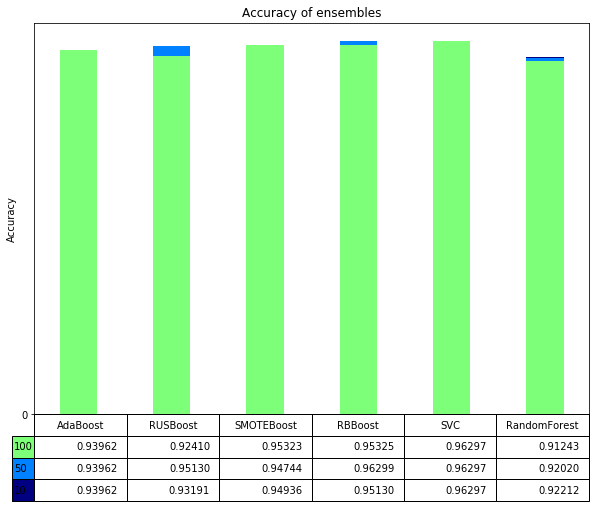

In [15]:
all_acc = np.concatenate((np.array(adaboost_accuracies).mean(axis=1).reshape(-1, 1), 
                          np.array(rusboost_accuracies).mean(axis=1).reshape(-1, 1),
                          np.array(smoteboost_accuracies).mean(axis=1).reshape(-1, 1),
                          np.array(rbboost_accuracies).mean(axis=1).reshape(-1, 1),
                          np.array([np.mean(svc_accuracies), np.mean(svc_accuracies), np.mean(svc_accuracies)]).reshape(-1, 1),
                          np.array(randomforest_accuracies).mean(axis=1).reshape(-1, 1)), axis=1)

columns = ('AdaBoost', 'RUSBoost', 'SMOTEBoost', 'RBBoost', 'SVC', 'RandomForest')
rows = ['100', '50', '10']

n_rows = len(all_acc)
index = np.arange(len(columns)) + 0.3
bar_width = 0.4
y_offset = np.zeros(len(columns))
colors = plt.cm.jet(np.linspace(0, 0.5, len(rows)))
values = np.arange(0, 10, 100)
value_increment = 1

cell_text = []
for row in range(n_rows):
    plt.bar(index, all_acc[row], bar_width, bottom=y_offset, color=colors[row])
    cell_text.append(['%1.5f' % (x) for x in all_acc[row]])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

fig = plt.gcf()
fig.set_size_inches(11,8)
plt.ylabel("Accuracy")
plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Accuracy of ensembles')
plt.show()

Based on this graph, we can understand that SMOTE, RUS and RB algrithms all achived higher accuracy score versus base AdaBoost classifier. Also we can see that RandomForest which does not boosting, has lowest score. Although SVM model has highest accuracy, in the following graphs we can see that SVM's high accuracy is due to focusing on majority class.

### 4.B Accuracies Bar Plot

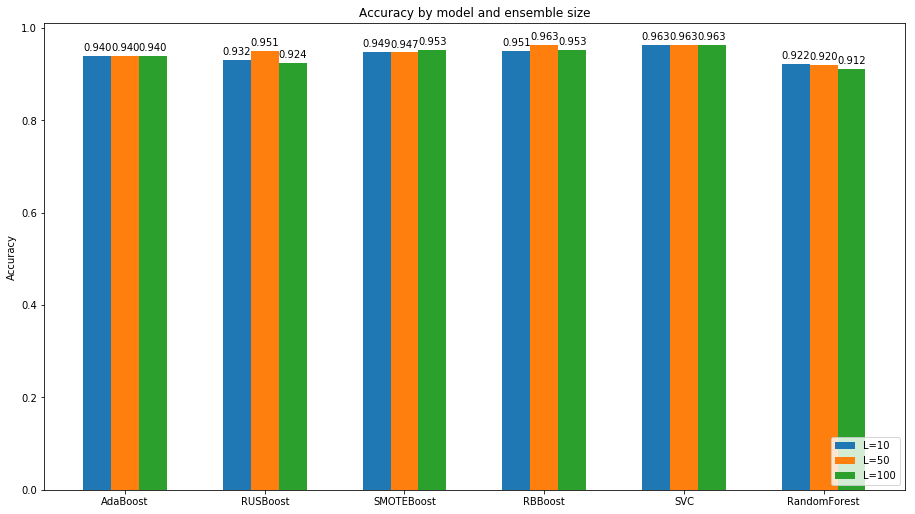

In [16]:
ensemble10 = all_acc[0]
ensemble50 = all_acc[1]
ensemble100 = all_acc[2]

values = np.arange(len(columns))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(values - width, ensemble10, width, label='L=10')
rects2 = ax.bar(values, ensemble50, width, label='L=50')
rects3 = ax.bar(values + width, ensemble100, width, label='L=100')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model and ensemble size')
ax.set_xticks(values)
ax.set_xticklabels(columns)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%0.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig = plt.gcf()
fig.set_size_inches(14,8)
plt.legend(loc="lower right")
plt.show()

On top of notes for previous graph, the outcome of this comparison is that increasing ensemble size in some cases increase score and some cases not but mostly it increases performance.

### 4.C Precisions-Recall Bar Plot

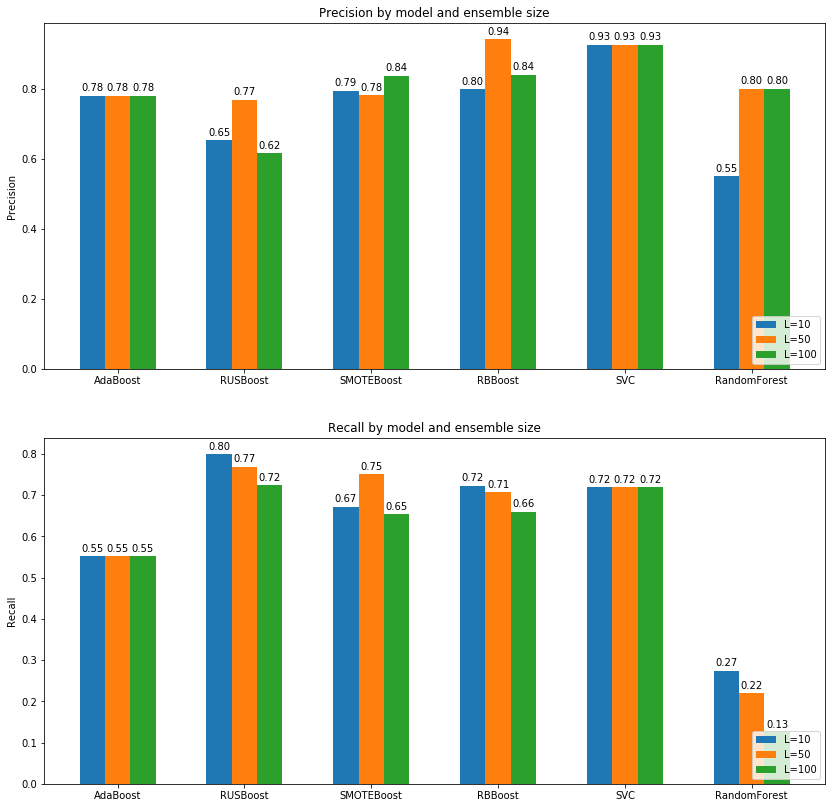

In [17]:
all_pr = np.concatenate((np.expand_dims(np.array(adaboost_pr).mean(axis=1), axis=1), 
                          np.expand_dims(np.array(rusboost_pr).mean(axis=1), axis=1),
                          np.expand_dims(np.array(smoteboost_pr).mean(axis=1), axis=1),
                          np.expand_dims(np.array(rbboost_pr).mean(axis=1), axis=1),
                          np.expand_dims(np.array([svc_pr[0], svc_pr[0],svc_pr[0]]).mean(axis=1), axis=1),
                          np.expand_dims(np.array(randomforest_pr).mean(axis=1), axis=1),
                        ), axis=1)

ensemble10_p = all_pr[0,:,0]
ensemble50_p = all_pr[1,:,0]
ensemble100_p = all_pr[2,:,0]

ensemble10_r = all_pr[0,:,1]
ensemble50_r = all_pr[1,:,1]
ensemble100_r = all_pr[2,:,1]

values = np.arange(len(columns))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(2)
rects10 = ax[0].bar(values - width, ensemble10_p, width, label='L=10')
rects20 = ax[0].bar(values, ensemble50_p, width, label='L=50')
rects30 = ax[0].bar(values + width, ensemble100_p, width, label='L=100')

rects11 = ax[1].bar(values - width, ensemble10_r, width, label='L=10')
rects21 = ax[1].bar(values, ensemble50_r, width, label='L=50')
rects31 = ax[1].bar(values + width, ensemble100_r, width, label='L=100')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision by model and ensemble size')
ax[0].set_xticks(values)
ax[0].set_xticklabels(columns)
ax[0].legend()

ax[1].set_ylabel('Recall')
ax[1].set_title('Recall by model and ensemble size')
ax[1].set_xticks(values)
ax[1].set_xticklabels(columns)
ax[1].legend()


def autolabel(rects, i):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax[i].annotate('%0.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        ax[i].legend(loc="lower right")


autolabel(rects10, 0)
autolabel(rects20, 0)
autolabel(rects30, 0)

autolabel(rects11, 1)
autolabel(rects21, 1)
autolabel(rects31, 1)

# fig.tight_layout()
fig = plt.gcf()
fig.set_size_inches(14,14)
plt.show()

For remembering recall and precision, precision can be defined that between all prediction that are positive, how many actually are positive and recall says that between all samples that are really positive, how many times we said positive.

What we can see from depicted graphs are that:

1. Increasing ensemble size causes increase in precision and decrease in recall. So finding best trade of between precision and recall is still challenge here as we can see highest recall is for RUSBoost while highest precision is obtained from RBBoost or SMOTEBoost or even SVM.
2. AdaBoost has recall around 0.55 which means it is working more like a sole weak classifier in this task while other extend version of this algorithm is doing much better with at least %20 and at max %30 percent increase in recall score.
3. Even though small ensemble sizes such as 10 or 50 are outperformed by base AdaBoost classifier in term of precision, we can see that increasing size in SMOTE, RUS or RB Boost algorithms increases precision immensely which is attributed to the stochastic behavior of these algorithms and theirs ability to capture general feature space.
4. As we can see, although RandomForest had a good accuracy, it has very low recall which means it iterally works much worse than a random classifier and labeling almost %90 of positive classes as negative and the reason is because of unbalanced data.
5. SVM model obtained good result in both precision-recall and accuracy but as we explained before, it is a stable model and putting it in an ensemble and increasing the size of ensemble to a large number like 1000 will not help at all while others like boosting approaches can achive better scores.

### 4.D AUC Bar Plot

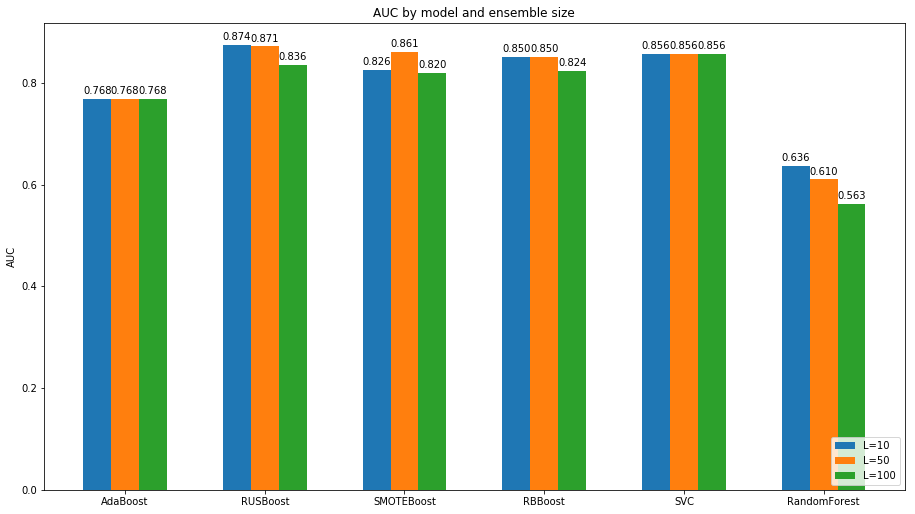

In [18]:
all_auc = np.concatenate((np.array(adaboost_auc).mean(axis=1).reshape(-1, 1), 
                          np.array(rusboost_auc).mean(axis=1).reshape(-1, 1),
                          np.array(smoteboost_auc).mean(axis=1).reshape(-1, 1),
                          np.array(rbboost_auc).mean(axis=1).reshape(-1, 1),
                          np.array([np.mean(svc_auc), np.mean(svc_auc), np.mean(svc_auc)]).reshape(-1, 1),
                          np.array(randomforest_auc).mean(axis=1).reshape(-1, 1)), axis=1)

ensemble10 = all_auc[0]
ensemble50 = all_auc[1]
ensemble100 = all_auc[2]

values = np.arange(len(columns))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(values - width, ensemble10, width, label='L=10')
rects2 = ax.bar(values, ensemble50, width, label='L=50')
rects3 = ax.bar(values + width, ensemble100, width, label='L=100')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC')
ax.set_title('AUC by model and ensemble size')
ax.set_xticks(values)
ax.set_xticklabels(columns)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%0.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig = plt.gcf()
fig.set_size_inches(14,8)
plt.legend(loc="lower right")
plt.show()

In simple terms we can say that higher AUC means model can distinguish between classes better. As we can see in many cases increasing ensemble size decreases AUC. And the reason is that as we saw before, increasing ensemble size decreases recall so Y factor of ROC decreases but as X factor of ROC curve depends on false positive and true negative ratios so it will not change much.

Depicted graphs demonstrate that:
1. All extended models of AdaBoost outperforms it by at least %8 percent increase in AUC score.
2. SMOTE, RB and RUS are hard to compare as the stochasticity in this models can have huge impact on scores and we using small size ensembles so cannot capture all feature space introduced by random behavior of this algorithsm.
3. SVM model is doing fine although we talked about its drawback in previous explanation of shown graphs.
4. As we saw before, RandomForest has lowest AUC score as we know it did not learned minority class.

### 4.E ROC Curve Plot

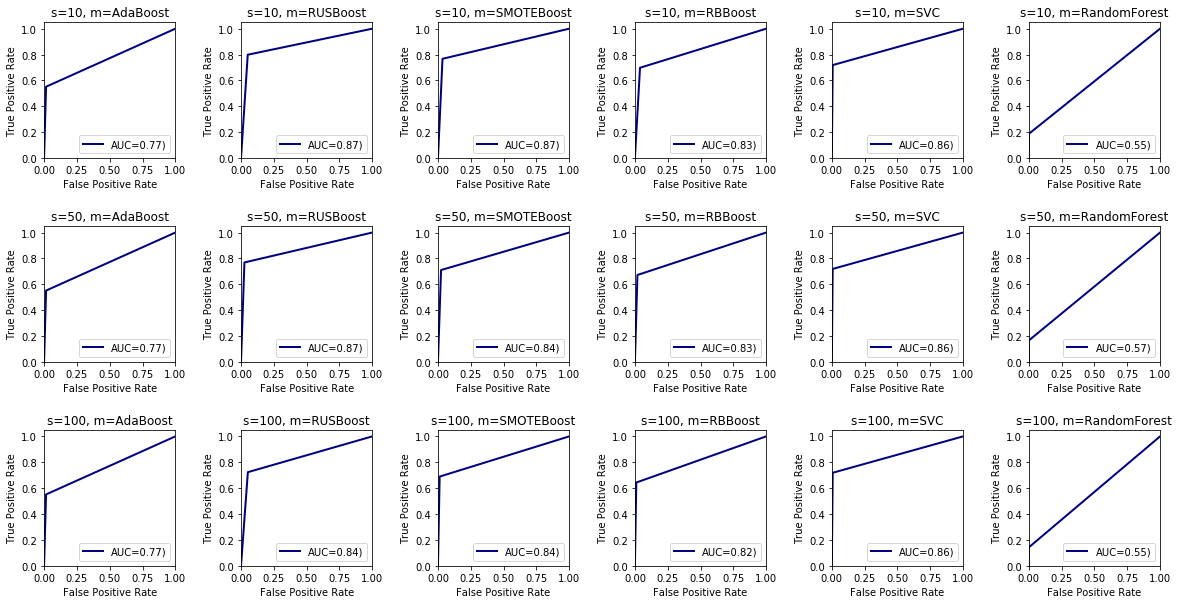

In [110]:
all_roc = np.concatenate((np.expand_dims(np.array(adaboost_roc).mean(axis=1), axis=1), 
                          np.expand_dims(np.array(rusboost_roc).mean(axis=1), axis=1),
                          np.expand_dims(np.array(smoteboost_roc).mean(axis=1), axis=1),
                          np.expand_dims(np.array(rbboost_roc).mean(axis=1), axis=1),
                          np.expand_dims(np.array([svc_roc[0], svc_roc[0],svc_roc[0]]).mean(axis=1), axis=1),
                          np.expand_dims(np.array(randomforest_roc).mean(axis=1), axis=1),
                        ), axis=1)

columns = ('AdaBoost', 'RUSBoost', 'SMOTEBoost', 'RBBoost', 'SVC', 'RandomForest')
rows = ['10', '50', '100']


fig, ax = plt.subplots(len(rows), len(columns))
fig.subplots_adjust(hspace=.5, wspace=0.5)

for i in range(len(rows)):
    for j in range(len(columns)):
        ax[i, j].set_title('s={}, m={}'.format(rows[i], columns[j]))
        ax[i, j].plot(all_roc[i][j][0], all_roc[i][j][1],
                      color='navy', lw=2, label='AUC=%0.2f)' % all_auc[i][j])
        ax[i, j].set_xlim([0.0, 1.0])
        ax[i, j].set_ylim([0.0, 1.05])
        ax[i, j].set_xlabel('False Positive Rate')
        ax[i, j].set_ylabel('True Positive Rate')
        ax[i, j].legend(loc="lower right")

fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

ROC curve are constructed of two factors: 1. Y: Recall=TP/(TP+FN) 2. X: FPR=FP/(TN+FP)

As we explaned before in AUC section, increasing ensemble size decreases recall so AUC will decrease which means that ROC curve will tend towards random model curve which is y=x.

Depiction outcomes:

1. RandomForest has almost same curve as random model y=x
2. SMOTEBoost and RUSBoost outperformed all other approaches but about %1 increase from SVM and %4 from their nearest opponent which is RBBoost while outperformed base AdaBoost by approximately %10 percent increase in score.
3. SVM model has the lowest FPR rate while SMOTE, RUS and RB achieved same rate by increasing in ensemble size. 
4. Recall of each ensemble decreases by increasing ensemble size as we can see in SMOTE, RUS and RB the curves tend toward y=x which means lower AUC score.
5. AdaBoost has low FPR rate but not as good as SVM meanwhile its very low recall failed it to have high AUC score.

## 5 ANOVA Measure
1. Preparing Data
2. Training Models
3. F-Score
4. HSD

### 5.A Preparing Data

In [9]:
from scipy.stats import f

K = 10  # n_folds

train_test_index = []
train_ratio = 0.7
train_size = round(train_ratio*len(x))

for k in range(K):
    train_idx = random.sample(list(np.arange(0, len(x))), train_size)
    test_idx = [idx for idx in list(np.arange(0, len(x))) if idx not in train_idx]
    train_test_index.append((train_idx, test_idx))

### 5.B Training Models

In [10]:
adaboost_accuracies = []  # accuracies of different ensembles given 5 folds

for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 folds
    for train_index, test_index in train_test_index:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = AdaBoostM2(x=x_train, y=y_train, n_classifier=es, base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        kf_acc.append(accuracy_score(y_test, y_pred))
    adaboost_accuracies.append(kf_acc)

In [11]:
rusboost_accuracies = []  # accuracies of different ensembles given 5 folds

for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 folds
    for train_index, test_index in train_test_index:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RUSBoost(x=x_train, y=y_train, n_classifier=es, base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        kf_acc.append(accuracy_score(y_test, y_pred))
    rusboost_accuracies.append(kf_acc)

In [12]:
smoteboost_accuracies = []  # accuracies of different ensembles given 5 folds

for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 folds
    for train_index, test_index in train_test_index:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = SMOTEBoost(x=x_train, y=y_train, n_classifier=es, smote_ratio=200
                           , base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        kf_acc.append(accuracy_score(y_test, y_pred))
    smoteboost_accuracies.append(kf_acc)

In [13]:
rbboost_accuracies = []  # accuracies of different ensembles given 5 folds

for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 folds
    for train_index, test_index in train_test_index:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RBBoost(x=x_train, y=y_train, n_classifier=es, base=DecisionTreeClassifier, max_depth=1)
        model.fit()
        y_pred = model.predict(x_test)
        kf_acc.append(accuracy_score(y_test, y_pred))
    rbboost_accuracies.append(kf_acc)

In [14]:
svc_accuracies = []  # accuracies of different ensembles given 5 folds
kf_acc = []  # accuracies of 5 fold

for train_index, test_index in train_test_index:
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = SVC(gamma='scale')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    kf_acc.append(accuracy_score(y_test, y_pred))
svc_accuracies.append(kf_acc)

In [15]:
randomforest_accuracies = []  # accuracies of different ensembles given 5 folds

for es in ensemble_sizes:
    kf_acc = []  # accuracies of 5 folds
    for train_index, test_index in train_test_index:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RandomForestClassifier(n_estimators=es, max_depth=1)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        kf_acc.append(accuracy_score(y_test, y_pred))
    randomforest_accuracies.append(kf_acc)

In [16]:
all_acc = np.concatenate((np.array(adaboost_accuracies).mean(axis=0).reshape(-1, 1), 
                          np.array(rusboost_accuracies).mean(axis=0).reshape(-1, 1),
                          np.array(smoteboost_accuracies).mean(axis=0).reshape(-1, 1),
                          np.array(rbboost_accuracies).mean(axis=0).reshape(-1, 1),
                          np.array(svc_accuracies).reshape(-1, 1),
                          np.array(randomforest_accuracies).mean(axis=0).reshape(-1, 1)), axis=1)

### 5.C F-Score

What is ANOVA test?

>In this notebook we used 6 different methods to work on our data and classify test data better but as the we saw in previous sections, the models achieved different ranking w.r.t. different metrics. This test tries to eliminate this problem and find the answer to the question that what the real differences between two or more groups are and are they really different from each other or not.

Assumptions?
> There are some assumption that we need to take care: 
1. Mean of samples within each group should be zero or very small number. We Took care of this by normalizing our data first place.
2. Values should come from normal distribution. If not, the probability of getting f_score > f_critical increases.

How does it work?

In simple terms, ANOVA tries to find that there is a significant difference between mean of two or more groups or not. But to be able to have honest decision, it needs between group variablity and within group variablity. 
1. Between-group variability: It refers to variations between the distributions of individual groups

![ss_between](wiki/2.png)

2. Within-group variablity: It refers to variations caused by differences within individual groups as not all the values within each group are the same.

high variability:

![ss_within](wiki/3.png)


less variablity:

![ss_within](wiki/4.png)

So as we can, both factors profoundly affect our decision to say that two distribution (groups) are from same population or not.

Here are the steps:
1. Calculate mean of whole data = `global_mean`
2. Calculate mean of all samples within a group = `group_means`
3. Calculate between group variability:
    1. Calculate the sum of squared differences between group_means and global_mean weighed with number of samples in each group = `ss_between`
    2. Normalize ss_between by defining `df_between` as the (number of groups - 1) 
    3. Calculate normalized ss_between by deviding it by df_between = `ms_between`
4. Calculate within group variability:
    1. Calculate the sum of squared differences between each sample within a group from its group mean = `ss_within`
    2. Normalize ss_within by defining `df_within` as the (number of samples - number of groups)
    3. Calculate normalized ss_within by deviding it by df_within = `ms_within`
5. Calculate F-score
    1. Calculate (ms_between / ms_within) = `f_score`
    2. Find `f_critical` from F-table (F-ditribution) using df_between as x-factor and df_within as y-factor (see [Here](https://www.dummies.com/education/math/business-statistics/how-to-find-the-critical-values-for-an-anova-hypothesis-using-the-f-table/))
    3. If f_score > f_critical then there is a honest significat difference between at least 2 groups.


Till now we just found out that there is a significant difference or not. But what is the degree of difference between different groups or simply which is better if they are different. To achieve the answer to this question, all we need to do is using Tukey's HSD test.

In [17]:
group_mean = all_acc.mean(axis=0)
global_mean = all_acc.mean()
n_groups = all_acc.shape[1]
n_instances = all_acc.shape[0]

f_threshold = 0.05

ss_between = np.sum(n_instances * (group_mean - global_mean) ** 2)
df_between = n_groups - 1
ms_between = ss_between / df_between

ss_within = np.sum((all_acc - group_mean.reshape(1, -1)) ** 2)
df_within = np.sum([n-1 for n in [n_instances]*n_groups])
ms_within = ss_within / df_within

f_score = ms_between / ms_within
f_critical = f.ppf(1-f_threshold, df_between, df_within)
if f_score > f_critical:
    print('There is huge difference between classes')

There is huge difference between classes


### 5.D HSD
We want to find the difference degree between each two pair of groups. To do so, HSD enables us to calculate it by values optained from ANOVA.

Note: HSD only works on ANOVA.

In the begining we said that ANOVA calculates that difference between means of two groups are significant or not. In HSD, we are doing same but for calculating this, we need to consider contriution of all samples and other groups while calculating the difference between two mean and this achieved by defining standard error of anova and normalizing each mean difference of any pair of groups by dividing it by standard error of anova.

Here are the steps:
1. Calculate standard error of ANOVA as square root of normalized ms_within = `se_anova`
2. Traverse within all unique pair of groups:
    1. Divide difference of means of the pair and divide it by se_anova = `q`
    2. If absolute value of q is bigger than f_critical then consider the difference as honest significant difference
    3. Report q as the difference

In [19]:
columns = ('AdaBoost', 'RUSBoost', 'SMOTEBoost', 'RBBoost', 'SVC', 'RandomForest')
se_anova = np.sqrt(ms_within / n_instances)

print('Help1: Pos diff means first class is better and vice versa.')
print('Help2: Higher diff means higher difference in performance and vice versa.\n')
for i in range(n_groups):
    for j in range(i, n_groups):
        q = (group_mean[i] - group_mean[j]) / se_anova
        if np.abs(q) > f_critical:
            print('HSD Between ---> {} & {} --> diff={}'.format(columns[i], columns[j], q-f_critical))

Help1: Pos diff means first class is better and vice versa.
Help2: Higher diff means higher difference in performance and vice versa.

HSD Between ---> AdaBoost & SVC --> diff=-7.21928216231305
HSD Between ---> AdaBoost & RandomForest --> diff=3.7705219977002473
HSD Between ---> RUSBoost & SMOTEBoost --> diff=-5.0903672203209425
HSD Between ---> RUSBoost & SVC --> diff=-8.139894029120427
HSD Between ---> RUSBoost & RandomForest --> diff=2.8499101308928703
HSD Between ---> SMOTEBoost & SVC --> diff=-5.435596670373702
HSD Between ---> SMOTEBoost & RandomForest --> diff=5.554207489639596
HSD Between ---> RBBoost & SVC --> diff=-5.78082612042646
HSD Between ---> RBBoost & RandomForest --> diff=5.208978039586837
HSD Between ---> SVC & RandomForest --> diff=8.603734298439083


Observations:

1. AdaBoost has not HSD from its variant like SMOTEBoost. (weird - maybe because of bad sampling of 10 folds or ensemble size)
2. RUSBoost outperformed by other boosting with huge HSD.
3. RandomForest is worst
4. SVC is the best with highest HSD from all other methods.